<a href="https://colab.research.google.com/github/smkerr/COVID-fake-news-detection/blob/main/model/fine-tuned-model-no-tweet2vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [2]:
# import dependencies
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
from xgboost import XGBClassifier

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')

from sklearn import preprocessing
from sklearn.ensemble import AdaBoostClassifier, VotingClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, plot_confusion_matrix, precision_score, recall_score
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

import pickle

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [3]:
#mount drive to save modesl
from google.colab import drive
drive.mount('drive')

Mounted at drive


In [4]:
# set seed
np.random.seed(42)

In [38]:
# load data 
train = pd.read_csv('https://raw.githubusercontent.com/smkerr/COVID-fake-news-detection/main/data/original%20data/Constraint_Train.csv', header=0)
val = pd.read_csv('https://raw.githubusercontent.com/smkerr/COVID-fake-news-detection/main/data/original%20data/Constraint_Val.csv', header=0)
test = pd.read_csv('https://raw.githubusercontent.com/smkerr/COVID-fake-news-detection/main/data/original%20data/Constraint_Test.csv', header=0)
new = pd.read_csv('new_data.csv', header=0)

In [ ]:
print(f"The training set contains {len(train)} observations.")
train.head()

The training set contains 6420 observations.


,id,tweet,label
0,1,The CDC currently reports 99031 deaths. In gen...,real
1,2,States reported 1121 deaths a small rise from ...,real
2,3,Politically Correct Woman (Almost) Uses Pandem...,fake
3,4,#IndiaFightsCorona: We have 1524 #COVID testin...,real
4,5,Populous states can generate large case counts...,real


In [39]:
# load & clean data 
train = pd.read_csv('https://raw.githubusercontent.com/smkerr/COVID-fake-news-detection/main/data/original%20data/Constraint_Train.csv', header=0)
train_clean = train[train["tweet"].map(len) <= 280].drop_duplicates() # drop posts longer than 280 characters & drop duplicates
X_train, y_train = train_clean["tweet"], train_clean["label"]


val = pd.read_csv('https://raw.githubusercontent.com/smkerr/COVID-fake-news-detection/main/data/original%20data/Constraint_Val.csv', header=0)
val_clean = val[val["tweet"].map(len) <= 280].drop_duplicates()  # drop posts longer than 280 characters & drop duplicates
X_val, y_val = val_clean["tweet"], val_clean["label"]

test = pd.read_csv('https://raw.githubusercontent.com/smkerr/COVID-fake-news-detection/main/data/original%20data/Constraint_Test.csv', header=0)
test_clean = test[test["tweet"].map(len) <= 280].drop_duplicates()  # drop posts longer than 280 characters & drop duplicates
X_test, y_test = test_clean["tweet"], test_clean["label"]

new = pd.read_csv('new_data.csv', header=0)
new_clean = new[new["statement"].map(len) <= 280].drop_duplicates()  # drop posts longer than 280 characters & drop duplicates
X_new, y_new = new_clean["statement"], new_clean["label"]


# This code drops posts longer than 280 characters: 
#X_train = train[train["tweet"].map(len) <= 280]

# Drop duplicates:
#X_train = train["tweet"].drop_duplicates()

# Pre-processing

In [40]:
# initialize lemmatizer 
lemmatizer = WordNetLemmatizer()

# create stop word list
stoplist = set(stopwords.words('english'))

# create CleanText() function
def CleanText(string):
    text = string.lower() # lowercase
    text = re.sub(r"http(\S)+",' ',text) # remove URLs   
    text = re.sub(r"www(\S)+",' ',text) # remove URLs
    text = re.sub(r"&",' and ',text) # replace & with ' and '
    text = text.replace('&amp',' ') # replace &amp with ' '
    text = re.sub(r"[^0-9a-zA-Z]+",' ',text) # remove non-alphanumeric characters
    text = text.split() # splits into a list of words
    text = [w for w in text if not w in stoplist] # remove stop words
    text = [lemmatizer.lemmatize(w) for w in text] # lemmatization
    text = " ".join(text) # joins the list of words
    return text

# apply CleanText() function to all tweets 
X_train = X_train.map(lambda x: CleanText(x))
X_val = X_val.map(lambda x: CleanText(x))
X_test = X_test.map(lambda x: CleanText(x))
X_new = X_new.map(lambda x: CleanText(x))

In [41]:
# initialize label encoder
label_encoder = preprocessing.LabelEncoder()

# encode 'fake' as 0 and 'real' as 1 to make target variables machine-readable
y_train = label_encoder.fit_transform(y_train)
y_val = label_encoder.fit_transform(y_val)
y_test = label_encoder.fit_transform(y_test)
y_new = label_encoder.fit_transform(y_new)

# Model Training

## #1 SVM

In [18]:
# create SVM object
svm_clf = SVC(kernel='linear',probability=True)

# create pipeline
svm_pipeline = Pipeline([
        ('bow', CountVectorizer(ngram_range=(1, 2))), # count term frequency
        ('tfidf', TfidfTransformer()), # downweight words which appear frequently
        ('c', svm_clf) # classifier
])

# train model
fit = svm_pipeline.fit(X_train,y_train)

# make predictions
svm_pred = svm_pipeline.predict(X_val)

#make pred on test
svm_pred_test = svm_pipeline.predict(X_test)





In [42]:
#make pred on new data
svm_pred_new = svm_pipeline.predict(X_new)

In [10]:
#save SVM model
#pkl_filename = "/content/drive/MyDrive/Final Project/COVID-fake-news-detection/model/saved models/pickle_svm_clf.pkl"
#with open(pkl_filename, 'wb') as file:
    #pickle.dump(svm_pipeline, file)

## #2 Logistic Regression

In [19]:
# create logistic regression object
lr_clf = LogisticRegression(max_iter=1000,penalty='none',solver='saga')

# create pipeline
lr_pipeline = Pipeline([
        ('count', CountVectorizer(ngram_range=(1, 2))), # count term frequency
        ('tfidf', TfidfTransformer()), # downweight words which appear frequently
        ('c', lr_clf) # classifier
])

# train model
fit = lr_pipeline.fit(X_train,y_train)

# make predictions
lr_pred = lr_pipeline.predict(X_val) 

#make pred on test
lr_pred_test = lr_pipeline.predict(X_test) 

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


In [44]:
#make pred on new
lr_pred_new = lr_pipeline.predict(X_new) 

In [31]:
#save lr model
#pkl_filename = "/content/drive/MyDrive/Final Project/COVID-fake-news-detection/model/saved models/pickle_lr_clf.pkl"
#with open(pkl_filename, 'wb') as file:
    #pickle.dump(lr_pipeline, file)

## #3 Extreme Gradient Boost

In [20]:
# create XGBoost object 
xgb_clf = XGBClassifier(max_depth=3, min_child_weight=3, eta = 0.15, n_estimators = 550, subsample=0.85)

# create pipeline
xgb_pipeline = Pipeline([
        ('bow', CountVectorizer(ngram_range=(1, 1))), # count term frequency
        ('tfidf', TfidfTransformer()), # downweight words which appear frequently
        ('c', xgb_clf) # classifier
])

# train model 
fit = xgb_pipeline.fit(X_train,y_train)

# make predictions
xgb_pred = xgb_pipeline.predict(X_val)

#make pred on test
xgb_pred_test = xgb_pipeline.predict(X_test)


In [45]:
#make pred on new data
xgb_pred_new = xgb_pipeline.predict(X_new)


In [30]:
#save xgb model
#pkl_filename = "/content/drive/MyDrive/Final Project/COVID-fake-news-detection/model/saved models/pickle_xgb_clf.pkl"
#with open(pkl_filename, 'wb') as file:
    #pickle.dump(xgb_pipeline, file)

## #4 Adaptive Boost

In [21]:
# create AdaBoost object
ada_clf = AdaBoostClassifier(n_estimators=500, learning_rate = 1.0)

# create pipeline
ada_pipeline = Pipeline([
        ('bow', CountVectorizer(ngram_range=(1, 2))), # count term frequency
        ('tfidf', TfidfTransformer()), # downweight words which appear frequently
        ('c', ada_clf) # classifier
])

# train model
fit = ada_pipeline.fit(X_train,y_train)

# make predictions
ada_pred = ada_pipeline.predict(X_val)

#make pred on test
ada_pred_test = ada_pipeline.predict(X_test)


In [46]:
#make pred on new data
ada_pred_new = ada_pipeline.predict(X_new)

In [29]:
#save ada model
#pkl_filename = "/content/drive/MyDrive/Final Project/COVID-fake-news-detection/model/saved models/pickle_ada_clf.pkl"
#with open(pkl_filename, 'wb') as file:
    #pickle.dump(ada_clf, file)

## #5 Voting Classifier

In [22]:
named_estimators = [ # for each of the individual models
    ("SVM", svm_pipeline),
    ("Logistic Regression", lr_pipeline),
    ("XGBoost", xgb_pipeline),
    ("AdaBoost", ada_pipeline)
]

In [23]:
# voting classifier
voting_clf = VotingClassifier(named_estimators, voting = "soft") #soft voting (predicts the class label based on the argmax of the sums of the predicted probabilities)

# train model
voting_clf.fit(X_train,y_train)

# make prediction
voting_pred = voting_clf.predict(X_val)

#make pred test
voting_pred_test = voting_clf.predict(X_test)


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


In [47]:
#make pred new data
voting_pred_new = voting_clf.predict(X_new)

In [28]:
#save ensemble model
#pkl_filename = "/content/drive/MyDrive/Final Project/COVID-fake-news-detection/model/saved models/pickle_voting_clf.pkl"
#with open(pkl_filename, 'wb') as file:
    #pickle.dump(voting_pipeline, file)

# Evaluation

In [24]:
# define print_metrics() function to print results
def print_metrics(pred,true):
    print(confusion_matrix(true,pred))
    print(classification_report(true,pred,))
    print("Accuracy : ",accuracy_score(pred,true))
    print("Precison : ",precision_score(pred,true, average = 'weighted'))
    print("Recall : ",recall_score(pred,true,  average = 'weighted'))
    print("F1 : ",f1_score(pred,true,  average = 'weighted'))

In [25]:
# define plot_confusion_matrix() function to display results
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(5, 4))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    #plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.xlabel('Predicted label')
    plt.show()

## #1 SVM

[[891  57]
 [ 62 863]]
              precision    recall  f1-score   support

           0       0.93      0.94      0.94       948
           1       0.94      0.93      0.94       925

    accuracy                           0.94      1873
   macro avg       0.94      0.94      0.94      1873
weighted avg       0.94      0.94      0.94      1873

Accuracy :  0.9364655632674853
Precison :  0.936483984102372
Recall :  0.9364655632674853
F1 :  0.9364680993228612


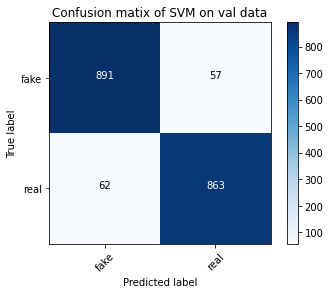

In [31]:
# display results
print_metrics(svm_pred, y_val)
plot_confusion_matrix(confusion_matrix(y_val,svm_pred),target_names=['fake','real'], normalize = False, \
                      title = 'Confusion matix of SVM on val data')

[[883  61]
 [ 70 834]]
              precision    recall  f1-score   support

           0       0.93      0.94      0.93       944
           1       0.93      0.92      0.93       904

    accuracy                           0.93      1848
   macro avg       0.93      0.93      0.93      1848
weighted avg       0.93      0.93      0.93      1848

Accuracy :  0.9291125541125541
Precison :  0.929174964750139
Recall :  0.9291125541125541
F1 :  0.9291217144067949


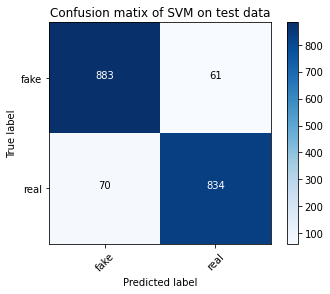

In [26]:
# display results test data
print_metrics(svm_pred_test, y_test)
plot_confusion_matrix(confusion_matrix(y_test,svm_pred_test),target_names=['fake','real'], normalize = False, \
                      title = 'Confusion matix of SVM on test data')

[[84 15]
 [16 57]]
              precision    recall  f1-score   support

           0       0.84      0.85      0.84        99
           1       0.79      0.78      0.79        73

    accuracy                           0.82       172
   macro avg       0.82      0.81      0.82       172
weighted avg       0.82      0.82      0.82       172

Accuracy :  0.8197674418604651
Precison :  0.820160830992306
Recall :  0.8197674418604651
F1 :  0.8199360878167905


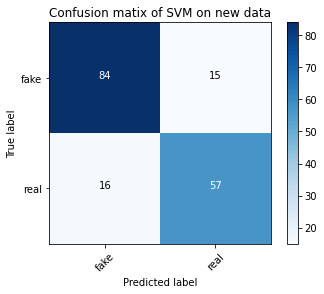

In [43]:
# display results new data
print_metrics(svm_pred_new, y_new)
plot_confusion_matrix(confusion_matrix(y_new,svm_pred_new),target_names=['fake','real'], normalize = False, \
                      title = 'Confusion matix of SVM on new data')

## #2 Logisitic Regression

[[896  52]
 [ 60 865]]
              precision    recall  f1-score   support

           0       0.94      0.95      0.94       948
           1       0.94      0.94      0.94       925

    accuracy                           0.94      1873
   macro avg       0.94      0.94      0.94      1873
weighted avg       0.94      0.94      0.94      1873

Accuracy :  0.9402028830752803
Precison :  0.9402456488806823
Recall :  0.9402028830752803
F1 :  0.9402071114683876


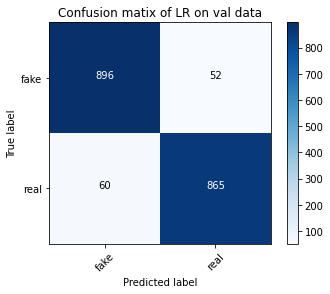

In [32]:
# display results
print_metrics(lr_pred, y_val)
plot_confusion_matrix(confusion_matrix(y_val,lr_pred),target_names=['fake','real'], normalize = False, \
                      title = 'Confusion matix of LR on val data')

[[880  64]
 [ 68 836]]
              precision    recall  f1-score   support

           0       0.93      0.93      0.93       944
           1       0.93      0.92      0.93       904

    accuracy                           0.93      1848
   macro avg       0.93      0.93      0.93      1848
weighted avg       0.93      0.93      0.93      1848

Accuracy :  0.9285714285714286
Precison :  0.9285874991964688
Recall :  0.9285714285714286
F1 :  0.9285751117855485


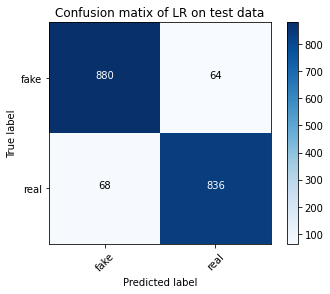

In [27]:
# display results test data
print_metrics(lr_pred_test, y_test)
plot_confusion_matrix(confusion_matrix(y_test,lr_pred_test),target_names=['fake','real'], normalize = False, \
                      title = 'Confusion matix of LR on test data')

[[83 16]
 [15 58]]
              precision    recall  f1-score   support

           0       0.85      0.84      0.84        99
           1       0.78      0.79      0.79        73

    accuracy                           0.82       172
   macro avg       0.82      0.82      0.82       172
weighted avg       0.82      0.82      0.82       172

Accuracy :  0.8197674418604651
Precison :  0.8195124227300078
Recall :  0.8197674418604651
F1 :  0.8196118489893891


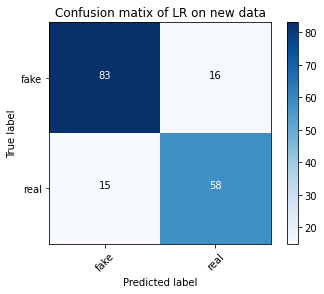

In [48]:
# display results new data
print_metrics(lr_pred_new, y_new)
plot_confusion_matrix(confusion_matrix(y_new,lr_pred_new),target_names=['fake','real'], normalize = False, \
                      title = 'Confusion matix of LR on new data')

## #3 Extreme Gradient Boost

[[883  65]
 [107 818]]
              precision    recall  f1-score   support

           0       0.89      0.93      0.91       948
           1       0.93      0.88      0.90       925

    accuracy                           0.91      1873
   macro avg       0.91      0.91      0.91      1873
weighted avg       0.91      0.91      0.91      1873

Accuracy :  0.9081687132941805
Precison :  0.9092251102738577
Recall :  0.9081687132941805
F1 :  0.9082402618904624


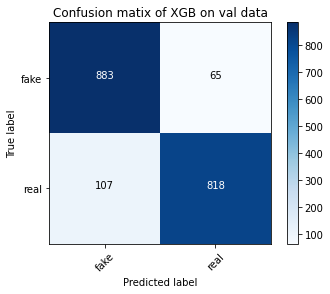

In [33]:
# display results
print_metrics(xgb_pred, y_val)
plot_confusion_matrix(confusion_matrix(y_val, xgb_pred),target_names=['fake','real'], normalize = False, \
                      title = 'Confusion matix of XGB on val data')

[[870  74]
 [115 789]]
              precision    recall  f1-score   support

           0       0.88      0.92      0.90       944
           1       0.91      0.87      0.89       904

    accuracy                           0.90      1848
   macro avg       0.90      0.90      0.90      1848
weighted avg       0.90      0.90      0.90      1848

Accuracy :  0.8977272727272727
Precison :  0.8988104572044127
Recall :  0.8977272727272727
F1 :  0.8978269187423803


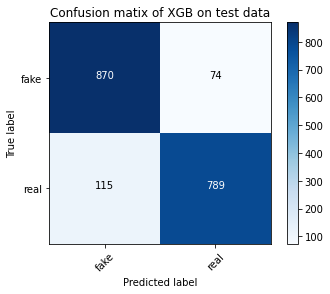

In [28]:
# display results on test data
print_metrics(xgb_pred_test, y_test)
plot_confusion_matrix(confusion_matrix(y_test, xgb_pred_test),target_names=['fake','real'], normalize = False, \
                      title = 'Confusion matix of XGB on test data')

[[88 11]
 [23 50]]
              precision    recall  f1-score   support

           0       0.79      0.89      0.84        99
           1       0.82      0.68      0.75        73

    accuracy                           0.80       172
   macro avg       0.81      0.79      0.79       172
weighted avg       0.80      0.80      0.80       172

Accuracy :  0.8023255813953488
Precison :  0.8165551661888074
Recall :  0.8023255813953488
F1 :  0.8055288342341449


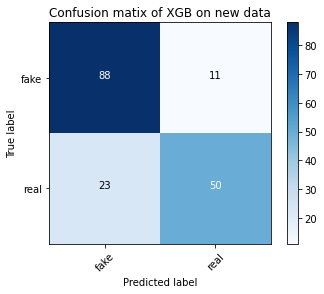

In [49]:
# display results new data
print_metrics(xgb_pred_new, y_new)
plot_confusion_matrix(confusion_matrix(y_new, xgb_pred_new),target_names=['fake','real'], normalize = False, \
                      title = 'Confusion matix of XGB on new data')

## #4 Adaptive Boost

[[846 102]
 [100 825]]
              precision    recall  f1-score   support

           0       0.89      0.89      0.89       948
           1       0.89      0.89      0.89       925

    accuracy                           0.89      1873
   macro avg       0.89      0.89      0.89      1873
weighted avg       0.89      0.89      0.89      1873

Accuracy :  0.8921516284036305
Precison :  0.8921510804363062
Recall :  0.8921516284036305
F1 :  0.8921503370597006


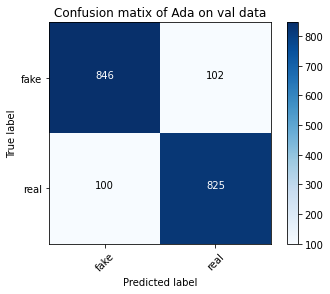

In [34]:
# display results
print_metrics(ada_pred,y_val)
plot_confusion_matrix(confusion_matrix(y_val,ada_pred),target_names=['fake','real'], normalize = False, \
                      title = 'Confusion matix of Ada on val data')

[[842 102]
 [100 804]]
              precision    recall  f1-score   support

           0       0.89      0.89      0.89       944
           1       0.89      0.89      0.89       904

    accuracy                           0.89      1848
   macro avg       0.89      0.89      0.89      1848
weighted avg       0.89      0.89      0.89      1848

Accuracy :  0.8906926406926406
Precison :  0.8906898607991679
Recall :  0.8906926406926406
F1 :  0.8906902071288683


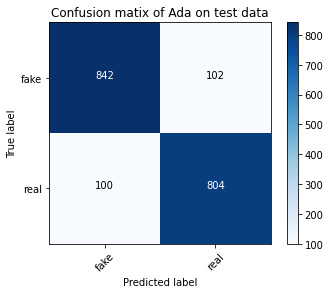

In [29]:
# display results on test data
print_metrics(ada_pred_test,y_test)
plot_confusion_matrix(confusion_matrix(y_test,ada_pred_test),target_names=['fake','real'], normalize = False, \
                      title = 'Confusion matix of Ada on test data')

[[82 17]
 [30 43]]
              precision    recall  f1-score   support

           0       0.73      0.83      0.78        99
           1       0.72      0.59      0.65        73

    accuracy                           0.73       172
   macro avg       0.72      0.71      0.71       172
weighted avg       0.73      0.73      0.72       172

Accuracy :  0.7267441860465116
Precison :  0.7448264100064036
Recall :  0.7267441860465116
F1 :  0.7316809603640977


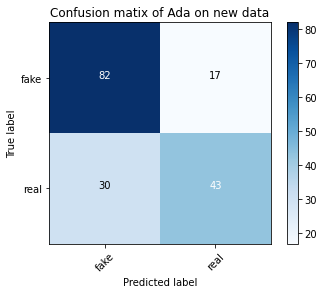

In [50]:
# display results new data
print_metrics(ada_pred_new,y_new)
plot_confusion_matrix(confusion_matrix(y_new,ada_pred_new),target_names=['fake','real'], normalize = False, \
                      title = 'Confusion matix of Ada on new data')

## #5 Voting Classifier

[[894  54]
 [ 64 861]]
              precision    recall  f1-score   support

           0       0.93      0.94      0.94       948
           1       0.94      0.93      0.94       925

    accuracy                           0.94      1873
   macro avg       0.94      0.94      0.94      1873
weighted avg       0.94      0.94      0.94      1873

Accuracy :  0.9369994660971703
Precison :  0.9370647472710771
Recall :  0.9369994660971703
F1 :  0.937005394223507


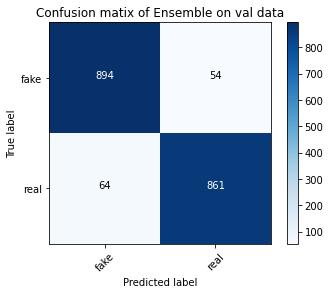

In [35]:
# display results
print_metrics(voting_pred,y_val)
plot_confusion_matrix(confusion_matrix(y_val,voting_pred),target_names=['fake','real'], normalize = False, \
                      title = 'Confusion matix of Ensemble on val data')

[[882  62]
 [ 76 828]]
              precision    recall  f1-score   support

           0       0.92      0.93      0.93       944
           1       0.93      0.92      0.92       904

    accuracy                           0.93      1848
   macro avg       0.93      0.93      0.93      1848
weighted avg       0.93      0.93      0.93      1848

Accuracy :  0.9253246753246753
Precison :  0.9254640149486032
Recall :  0.9253246753246753
F1 :  0.9253412202939015


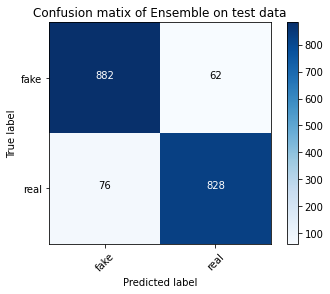

In [30]:
# display results
print_metrics(voting_pred_test,y_test)
plot_confusion_matrix(confusion_matrix(y_test,voting_pred_test),target_names=['fake','real'], normalize = False, \
                      title = 'Confusion matix of Ensemble on test data')

[[84 15]
 [15 58]]
              precision    recall  f1-score   support

           0       0.85      0.85      0.85        99
           1       0.79      0.79      0.79        73

    accuracy                           0.83       172
   macro avg       0.82      0.82      0.82       172
weighted avg       0.83      0.83      0.83       172

Accuracy :  0.8255813953488372
Precison :  0.8255813953488372
Recall :  0.8255813953488372
F1 :  0.8255813953488372


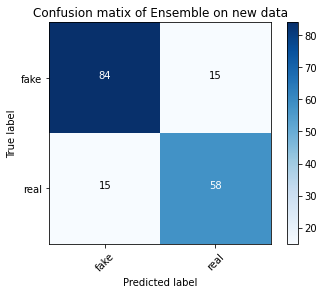

In [51]:
# display results new data
print_metrics(voting_pred_new,y_new)
plot_confusion_matrix(confusion_matrix(y_new,voting_pred_new),target_names=['fake','real'], normalize = False, \
                      title = 'Confusion matix of Ensemble on new data')

# Error Analysis

In [ ]:
# error analysis, to compare the false classifications of the different models
false_pred_svm = val[(y_val != svm_pred)]
false_pred_xgb = val[(y_val != xgb_pred)]
false_pred_lr = val[(y_val != lr_pred)]
false_pred_ada = val[(y_val != ada_pred)]
false_pred_ensemble = val[(y_val != voting_pred)]

# compile common mistakes
common_mistakes_df = false_pred_svm = false_pred_gb = false_pred_lr = false_pred_xg = false_pred_ada = false_pred_ensemble

# inspect df
print(f"{len(common_mistakes_df)} tweets have consistently been misclassified by all of our classifiers.\nThat's about {100*round(len(common_mistakes_df)/len(y_val),1)}% of tweets.")
common_mistakes_df.head()

136 tweets have consistently been misclassified by all of our classifiers.
That's about 10.0% of tweets.


,id,tweet,label
1,2,11 out of 13 people (from the Diamond Princess...,fake
10,11,You can still fly the friendly skies without f...,real
13,14,Tomorrow April 6 we will pass 10000 coronaviru...,real
17,18,Gov. Andrew Cuomo “was simply saying if we can...,fake
25,26,Breathlessness excessive fatigue and muscle ac...,real


In [ ]:
# save 'common_mistakese' as .csv
common_mistakes_df = pd.merge(false_pred_svm, false_pred_ada, on=['tweet'], how='inner')
print(common_mistakes_df)

TypeError: merge() got multiple values for argument 'on'

In [ ]:
# mount drive to save data
from google.colab import drive
drive.mount('drive')

In [ ]:
# save to Google Drive
common_mistakes.to_csv('/content/drive/MyDrive/Final Project/COVID-fake-news-detection/model/error_analysis/common_mistakes.csv', encoding='utf-8')